# Temporal Difference Learning Exercises

**NOTICE:**
1. You are allowed to work in groups of up to three people but **have to document** your group's\
 members in the top cell of your notebook.
2. **Comment your code**, explain what you do (refer to the slides). It will help you understand the topics\
 and help me understand your thinking progress. Quality of comments will be graded.
3. **Discuss** and analyze your results, **write-down your learnings**. These exercises are no programming\
 exercises it is about learning and getting a touch for these methods. Such questions might be asked in the\
 final exams.
 4. Feel free to **experiment** with these methods. Change parameters think about improvements, write down\
 what you learned. This is not only about collecting points for the final grade, it is about understanding\
  the methods.

In [1]:
# If you run on google-colab you have to install this package whenever you start a kernel
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 5.1 MB/s eta 0:00:0000:0100:01


In [4]:
#@title **Provided Code:** ``visualize_taxi_policy()`` and ``test_taxi_policy()`` function.

from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np

def visualize_taxi_policy(env, Q, delay=0.175):
    '''
        Visualize a taxi policy.
        env - Taxi-v3 environment.
        Q - a Q-table with Q[i, k] giving the action-value for action k taken in state i.
    '''
    s, _ = env.reset()
    plt.imshow(env.render())

    while True:
        if isinstance(Q, np.ndarray):
            a = np.argmax(Q[s])
        elif isinstance(Q, tf.keras.Sequential):
            q = Q.predict([s], verbose=0)
            a = np.argmax(q)
        else:
            raise Exception("Q is expected to be either a np.array or a tf.keras.Sequential type")
        s,_,terminated,truncated,_ = env.step(a)
        plt.imshow(env.render())
        plt.show()
        display.clear_output(wait=True)
        time.sleep(delay)

        if terminated or truncated:
            break


def test_taxi_policy(env, Q):
    '''
        Test a taxi policy.
        env - Taxi-v3 environment.
        Q - a Q-table with Q[i, k] giving the action-value for action k taken in state i.
        returns: success-rate, average reward per step
    '''

    success = 0
    rewards = []

    for it in range(100):
        s, _ = env.reset()
        while True:
            if isinstance(Q, np.ndarray):
                a = np.argmax(Q[s])
            elif isinstance(Q, tf.keras.Sequential):
                q = Q.predict([s], verbose=0)
                a = np.argmax(q)
            else:
                raise Exception("Q is expected to be either a np.array or a tf.keras.Sequential type")

            s,r,terminated,truncated,_ = env.step(a)
            rewards.append(r)
            if terminated:
                success += 1
            if terminated or truncated:
                break
    return success/100, np.mean(rewards)


### Exercise 1 - Q-Learning

**Summary:** In this exercise we will use the ``Taxi-v3`` environment to implement and test   
the Q-learning algorithm. We will use the same algorithm later to extend it with neural nets  
to Deep Q-learning (DQN) which is today used in various state-of-the-art AI models.

**So, make sure you understand it deeply!**

**Hints:**
* Use ```env.action_space.n``` to find the number of possible actions.
* Use ```env.observation_space.n``` to find the number of possible states.
* You can sample a random action using ```env.action_space.sample()```.
* You can use ```np.argmax(...)``` with appropriate indexing into the ```Q```   
array to get the index with the highest value (e.g.: for $max_a Q(S_{t+1}, a)$).

**Provided Code:** The cells below contains code to initialize the ```Taxi-v3``` environment.  
Use the ```test_taxi_policy(env, Q)``` method and ```visualize_taxi_policy(env, Q)``` with your   
Q-table as argument to test and visualize the greedy policy derived from a Q table.


**Your Tasks in this exercise:**
1. Implement the Q-learning algorithm
2. Test your implementation using using the ```test_taxi_policy(env, Q)```
3. Answer and discuss:
    * Why is Q-learning an off-policy algorithm?
    * What is the role of the epsilon-greedy strategy in Q-learning?
    * Does the Q-learning algorithm converge without reducing the exploration rate over time?
    


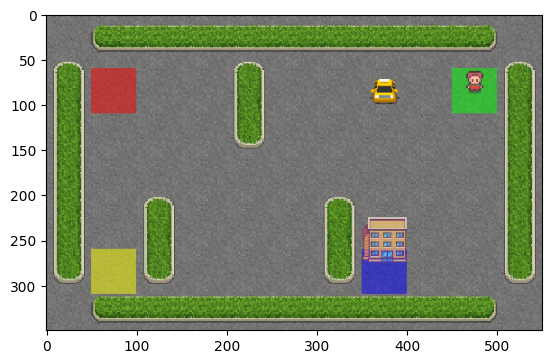

In [5]:
import gymnasium as gym
env = gym.make('Taxi-v3', render_mode='rgb_array')

s_t = env.reset()
plt.imshow(env.render())

In [20]:
def q_learning(env, n_episodes, alpha, gamma, epsilon):
    # get number of states and actions
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # init Q with all zeros
    Q = np.zeros((n_states, n_actions))

    # loop over episodes
    for episode in range(n_episodes):
        # reset env to get start state
        s, _ = env.reset()
        # set termination-flags to false
        terminated = False
        truncated = False

        # run episode until termiantion
        while not (terminated or truncated):
            # epsilon-greedy to select an action
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s])

            # take action in the environment and observe next state and reward
            s_next, r, terminated, truncated, _ = env.step(a)

            # update of Q-value with off-policy formula
            Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])

            # move to next state
            s = s_next

    return Q

In [15]:
Q = q_learning(env, n_episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1)
test_taxi_policy(env, Q)

(1.0, np.float64(0.5861027190332326))

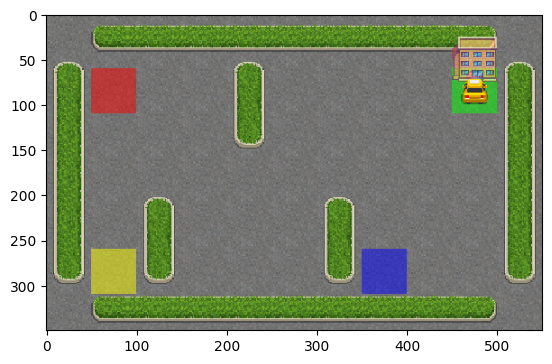

In [18]:
visualize_taxi_policy(env, Q, delay=0.125)

# Answers

3. Answer and discuss:

    * Why is Q-learning an off-policy algorithm?

    We use a seperate policy (here greedy-policy) to get next a in the q-learning-update to estimate the value of the next state --> Off-policy 

    * What is the role of the epsilon-greedy strategy in Q-learning?

    It makes sure that there is some kind of exploration, so we will sometimes try something knew instead of sticking to that what we think is working best. Without it, we could get stuck in a not optimal policy.

    * Does the Q-learning algorithm converge without reducing the exploration rate over time?

    Yes, the q-learning algorithm converge without reducing the exploration rate over time. However, reducing it could speed convergence.   

### Exercise 2 - Sarsa


In this exercise we will use the ``Taxi-v3`` environment to implement and test   
the Sarsa algorithm.


**Hints:**
* Use ```env.action_space.n``` to find the number of possible actions.
* Use ```env.observation_space.n``` to find the number of possible states.
* You can sample a random action using ```env.action_space.sample()```.
* You can use ```np.argmax(...)``` with appropriate indexing into the ```Q```   
array to get the index with the highest value (e.g.: for $max_a Q(S_{t+1}, a)$).



**Provided Code:** The cells below contains code to initialize the ```Taxi-v3``` environment.  
Use the ```test_taxi_policy(env, Q)``` method and ```visualize_taxi_policy(env, Q)``` with your   
Q-table as argument to test and visualize the greedy policy derived from a Q table.


**Your Tasks in this exercise:**
1. Implement the Sarsa algorithm
    * Implement a flag that activates exploration decay (reducing the learning rate)   
    over time.
2. Test your implementation using using the ```test_taxi_policy(env, Q)```
3. Compare the convergence of the algorithm with exploration decay and without
4. Answer and discuss:
    * Why is Sarsa an on-policy algorithm?
    * What is the impact of exploration decay in Sarsa?

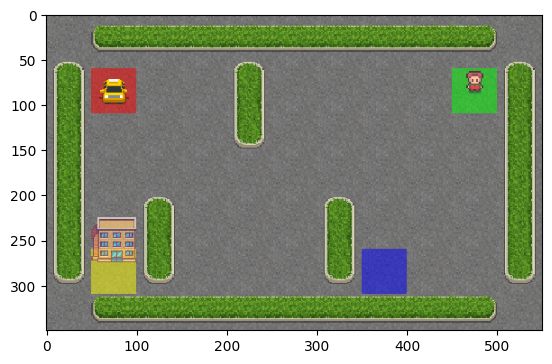

In [19]:
import gymnasium as gym
env = gym.make('Taxi-v3', render_mode='rgb_array')

s_t = env.reset()
plt.imshow(env.render())

In [22]:
def sarsa(env, n_episodes, alpha, gamma, epsilon, decay):
    # get number of states and actions
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # init Q with all zeros
    Q = np.zeros((n_states, n_actions))

    # loop over episodes
    for episode in range(n_episodes):
        # reset env to get start state
        s, _ = env.reset()
        # set termination-flags to false
        terminated = False
        truncated = False

        # epsilon-greedy to select an action
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s])

        # run episode until termination
        while not (terminated or truncated):
            # take action and observe next state and reward
            s_next, r, terminated, truncated, _ = env.step(a)

            # choose next action for s_next using e-greedy
            if np.random.rand() < epsilon:
                a_next = env.action_space.sample()
            else:
                a_next = np.argmax(Q[s_next])

            # update of Q-value with on-policy formula
            Q[s, a] = Q[s,a ] + alpha * (r + gamma * Q[s_next, a_next] - Q[s, a])

            # move to next state and action
            s, a = s_next, a_next

        #  if we set decay flag, decay epsilon
        if decay:
            epsilon = epsilon * 0.995

    return Q

In [33]:
Q = sarsa(env, n_episodes=500, alpha=0.1, gamma=0.9, epsilon=0.1, decay=False)
print(test_taxi_policy(env, Q))
Q = sarsa(env, n_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=False)
print(test_taxi_policy(env, Q))
Q = sarsa(env, n_episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=False)
print(test_taxi_policy(env, Q))
Q = sarsa(env, n_episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=False)
print(test_taxi_policy(env, Q))

(0.04, np.float64(-1.3691107644305773))
(0.4, np.float64(-0.9323998068565911))
(0.93, np.float64(-0.24826789838337182))
(0.98, np.float64(0.20280537697253068))


In [34]:
Q = sarsa(env, n_episodes=500, alpha=0.1, gamma=0.9, epsilon=0.1, decay=True)
print(test_taxi_policy(env, Q))
Q = sarsa(env, n_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=True)
print(test_taxi_policy(env, Q))
Q = sarsa(env, n_episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=True)
print(test_taxi_policy(env, Q))
Q = sarsa(env, n_episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=True)
print(test_taxi_policy(env, Q))

(0.09, np.float64(-1.3821196038737211))
(0.52, np.float64(-1.2461719670200235))
(1.0, np.float64(0.5801354401805869))
(1.0, np.float64(0.600609756097561))


# Answers

4. Answer and discuss:

    * Why is Sarsa an on-policy algorithm?

    Sarsa uses the current policy (in this example is it the epsilon-greedy-policy) to choose the next action A'. The policy that is used to generate actions is the same as the one being evaluated.

    * What is the impact of exploration decay in Sarsa?

    We have high epsilon at the beginning => more exploring, test out actions and get better estimates for them. Later its lower epsilon -> exploit learned Q-values.
    This seem to speed up the convergence here, we are hitting a successrate of 1.0 much earlier, while the one without decay is not hitting 1.0 at all for the given number of episodes.

### Exercise 3 - Deep Sample-Averaging (single State, single Action)

Sample-averaging is an iterative way to estimate the mean (such as the mean of    
rewards) using the update rule $Q_{n+1} \leftarrow Q_n + \alpha [r_{n} - Q_n]$.

In this exercise we will use a neural net to perform sample-averaging.   
Once you understand how we employ a neural net to do so (and how it  
*bootstraps* in particular) moving to deep temporal difference learning  
will be easy.


**Provided Code:** The cells below give you a sample implementation of   
the sample-averaging and the environment we use (it's just a one-armed bandit).   
Use it as your skeleton for your deep sample-averaging implementation. To save   
some time, I have also provided you with code that initializes and prepares a    
neural net for regression using keras (you should know how to do this at this)
point.

**Hints:**
* ```model.predict(np.array([s_t]))``` - predicts the mean reward of state s_t
* ```model.fit(xs, ys)``` - fits your neural network for a batch of states    
(xs) and labels (ys)
* You can convert a list x to a np.array using ```np.array([x])```


**Your Tasks in this exercise:**
1. Implement the Deep Sample-Averaging


In [35]:
import numpy as np

class SampleAveragingEnv:
    def __init__(self, num_states = 3, num_actions=5):
        self._max_steps = 100
        self._step = 0

        self._mus = 10 * np.random.randn(num_states, num_actions)
        self._sigmas = np.random.randn(num_states, num_actions)
        self._states = np.arange(num_states)
        self._actions = np.arange(num_actions)

    def __compute_reward__(self, state, action):
        return self._mus[state,action] + self._sigmas[state,action] * np.random.randn()

    def action_space(self):
        return self._actions

    def state_space(self):
        return self._states

    def step(self, action):
        self._step += 1

        terminated = False
        truncated = self._step >= self._max_steps
        reward = self.__compute_reward__(self._state, action)


        # Transition to random state
        #
        self._state = np.random.choice(self._states)

        return self._state,reward, terminated, truncated

    def reset(self):
        # Transition to random state
        #
        self._step = 0
        self._state = np.random.choice(self._states)
        return self._state

    def print_means(self):
        for state in self._states:
            for action in self._actions:
                print("Mean(S-%d, A-%d): %f" % (state, action, self._mus[state, action]))

    def get_means(self):
        return self._mus

#### Use the code below as a reference, change the required parts with a neural net.

In [36]:
# Average sampling using a simple environment with a single state and a
# single action.
#
env = SampleAveragingEnv(num_states = 1, num_actions = 1)
M = np.random.randn()
alpha = 0.01

for e in range(1000):
    s_t = env.reset()
    while True:
        a_t = 0 # only one action, boring ...
        s_tplus1, r_tplus1, terminated, truncated = env.step(a_t)

        # By observing r_tplus1 we get one piece of real information
        # that moves our estimate more towards the real mean of
        # the reward distribution.
        #
        M = M + alpha * (r_tplus1 - M)
        if truncated or terminated:
            break

        s_t = s_tplus1

print('Estimated mean: %f' % M)
env.print_means()

Estimated mean: 3.607936
Mean(S-0, A-0): 3.599855


In [39]:
!pip install tensorflow

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Sequential

# create environment
env = SampleAveragingEnv(num_states = 1, num_actions = 1)

# build neural network model
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear')) # we want to predict a single value

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt) # use MSE loss

num_episodes = 100
for e in range(num_episodes):
    s_t = env.reset()

    while True:
        a_t = 0 # only one action, boring ...
        s_tplus1, r_tplus1, terminated, truncated = env.step(a_t)

        # this is the target
        y_n = np.array([r_tplus1])
        
        # train network to predict target
        model.fit(np.array([s_t]), y_n, verbose=0)
        
        # move to next state
        s_t = s_tplus1

        # break if we finished
        if truncated or terminated:
            break

In [65]:
predicted_mean = model.predict(np.array([0]))[0,0]
print('Predicted mean: %f' % predicted_mean)
env.print_means()

print("Looks not to bad! I did only train for 100 episodes though.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted mean: -12.231782
Mean(S-0, A-0): -12.357944
Looks not to bad! I did only train for 100 episodes though.


### Exercise 4 - Deep Average-Sampling (multiple States, multiple Actions)


In this exercise you will extend your previous solution to work with multiple actions.


**Provided Code:** Use your implementation from Exercise 3 as a start. The cell below
initializes a neural net with 4 outputs for you.

**Hints:**
At this point you might need some more control over your training. See the code sample   
below how we can manually compute gradients and apply them for a training step using tf.    

```python
...
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
with tf.GradientTape () as tape:
    tape.watch(model.trainable_weights)
    # Do your stuff to compute the loss.
    #
    loss = ...
    # Compute gradients using tf.
    #
    grads = tape.gradient(loss, model.trainable_weights)
    # Apply a step of optimization to network weights.
    #
    opt.apply_gradients(zip(grads, model.trainable_weights))
```

**Also Notice:** In each time-step you will have to decide for one action, this means the environment   
will give you only a single reward (the reward for the taken action). For training the net, we want to   
**IGNORE** the action we did not take (we have no useful information at this point).

We can accomplish this by masking out the actions we did not take, i.e.: multiply them element-wise   
with a one-hot encoded vector indicating the selected action:    
```mask = tf.one_hot(a_t, depth=num_actions, on_value=1, off_value=0, dtype=tf.float32)```




**Your Tasks in this exercise:**
1. Implement the Deep Sample-Averaging for **two states with four actions per state**
2. Explain how the masking affects the gradients of the neural net   
(why does it work, what does it accomplish)?
3. Explain how you could make the training of the net more stable.




In [76]:
# This will help you initialize your neural net.
#
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Sequential

num_actions = 4
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_actions, activation='linear')) # 4 values in output

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt) # use MSE loss

env = SampleAveragingEnv(num_states = 2, num_actions = num_actions) # create env with 2 states and 4 actions

num_episodes = 100 # train for 100 episodes

for e in range(num_episodes):
    s_t = env.reset()

    while True:
        # just do random actions here - we have no policy
        a_t = np.random.randint(num_actions)

        # do the step in the environment
        s_tplus1, r_tplus1, terminated, truncated = env.step(a_t)

        # use a tensor for state input
        s_input = tf.convert_to_tensor([[s_t]], dtype=tf.float32)

        # do the masking for the taken action
        mask = tf.one_hot(a_t, depth=num_actions, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            # we predict Q-values for all the actions
            q_values = tf.squeeze(model(s_input))

            # now we compute the loss only for the taken action (using the mask)
            loss = tf.reduce_mean(mask * (q_values - r_tplus1) ** 2)

        # get the gradient and update the weights
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        # move to next state
        s_t = s_tplus1

        # stop if the episode ended
        if terminated or truncated:
            break

In [78]:
for s in range(env.state_space().size):
    # Convert state to tensor
    s_input = tf.convert_to_tensor([[s]], dtype=tf.float32)

    # Get predicted Q-values for all actions
    q_pred = tf.squeeze(model(s_input)).numpy()  # shape = [num_actions]

    print(f"State {s}:")
    print("Predicted Q-values:", np.round(q_pred, 3))

env.print_means()
print("Doesnt look too bad also here! Again only 100 episodes of training. Not all values are spot on.")

State 0:
Predicted Q-values: [-12.831  -5.868   5.306  -1.006]
State 1:
Predicted Q-values: [  8.066 -16.467  -1.425  12.464]
Mean(S-0, A-0): -12.883187
Mean(S-0, A-1): -5.677632
Mean(S-0, A-2): 5.336609
Mean(S-0, A-3): -0.865483
Mean(S-1, A-0): 8.448777
Mean(S-1, A-1): -18.359656
Mean(S-1, A-2): -1.238188
Mean(S-1, A-3): 13.286162
Doesnt look too bad also here! Again only 100 episodes of training. Not all values are spot on.


### Exercise 5 - Double Deep-Q Learning

In this exercise I provide you with my implementation of Double DQN. Use the code to solve the CartPole-V1 environment  
(average reward of 500). Read through the code and try to match your theoretical knowledge from the lecture with the   
implementation.


**Provided Code:**
The cell below gives you a simple implementation of a ```ReplayBuffer```, an implementation of   
```soft-updates``` and a straight forward implementation of ```Double DQN```.


**Your Tasks in this exercise:**
1. Read through the code and try to understand what it does.
2. Solve the CartPole-v1 environment.
3. Explain which techniques were applied and why these techniques are used. Also explain what is    
different from theory (and why)?

In [8]:
import numpy as np


class ReplayBuffer:
    ''' This implements a simple version of a replay memory.'''

    def __init__(self, state_shape, action_shape, buffer_size=5000):
        self._state_t = np.zeros((buffer_size, *state_shape))
        self._state_tplus1 = np.zeros((buffer_size, *state_shape))
        self._action_t = np.zeros((buffer_size, *action_shape))
        self._reward_tplus1 = np.zeros((buffer_size, 1))
        self._is_nonterminal = np.zeros((buffer_size, 1))
        self._is_greedy_action = np.zeros((buffer_size, 1))
        self._cur_idx = 0
        self._len = 0
        self._buffer_size = buffer_size
        self._is_filled = False

    def store_transition(self, s_t, a_t, r_tplus1, s_tplus1, is_nonterminal, is_greedy_action):
        self._state_t[self._cur_idx,:] = s_t
        self._state_tplus1[self._cur_idx,:] = s_tplus1
        self._action_t[self._cur_idx,:] = a_t
        self._reward_tplus1[self._cur_idx,:] = r_tplus1
        self._is_nonterminal[self._cur_idx,:] = is_nonterminal
        self._is_greedy_action[self._cur_idx,:] = is_greedy_action

        self._cur_idx += 1
        if self._cur_idx >= self._buffer_size:
            self._cur_idx = 0
            self._len = self._buffer_size
            self._is_filled = True


    def start_epoch(self, batch_size, max_samples=None):
        if max_samples is None:
            max_samples = self.len()

        if max_samples > self.len():
            max_samples = self.len()

        self._batch_idx = 0
        self._batch_size = batch_size
        self._batch_max_idx = np.floor(max_samples / self._batch_size)-1

        self._batch_indices = np.arange(self.len())
        np.random.shuffle(self._batch_indices)

    def has_batch(self):
        return self._batch_idx < self._batch_max_idx

    def get_minibatch(self):
        indices = self._batch_indices[self._batch_idx*self._batch_size: self._batch_idx*self._batch_size+self._batch_size]
        self._batch_idx += 1
        return self._state_t[indices, :], self._action_t[indices, :], self._reward_tplus1[indices, :], self._state_tplus1[indices, :], self._is_nonterminal[indices,:]

    def sample_minibatch(self, batch_size):
        indices = np.random.choice(np.arange(self.len()), batch_size, replace=False)
        return self._state_t[indices, :], self._action_t[indices, :], self._reward_tplus1[indices], self._state_tplus1[indices, :], self._is_nonterminal[indices,:]

    def len(self):
        if self._is_filled:
            return self._buffer_size
        else:
            return self._cur_idx

    def stats(self):
        fill_prct = (self.len() * 100) / self._buffer_size
        nonterminal_prct = (np.sum(self._is_nonterminal)  * 100) / self.len()
        terminal_prct = 100 - nonterminal_prct
        greedy_action_prct = (np.sum(self._is_greedy_action[0:self.len()])) * 100 / self.len()
        exploratory_action_prct = 100 - greedy_action_prct

        avg_reward = np.mean(self._reward_tplus1[0:self.len()])
        std_reward = np.std(self._reward_tplus1[0:self.len()])

        return "[#trans: %d - %%fil: %.01f - %%terminal: %.01f - %%exp-actions: %.01f]" \
                % (self.len(), fill_prct, terminal_prct, exploratory_action_prct)



def update_target_weights(net_A, net_B, tau=0.001):
    ''' Performs a soft update using the weights of net_A updating net_B
        via linear interpolation.
    '''

    for i in range(len(net_A.layers)):

        layer_weights_list_A = net_A.layers[i].get_weights()
        layer_weights_list_B = net_B.layers[i].get_weights()

        new_weights = []
        for (w_src, w_target) in zip(layer_weights_list_A, layer_weights_list_B):
            w_target = w_src * tau + (1.0-tau) * w_target
            new_weights.append(w_target)

        net_B.layers[i].set_weights(new_weights)



import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

def create_net(input_dim, action_dim):
    net = Sequential()
    net.add(Input(shape=(input_dim,)))
    net.add(Dense(32, activation='relu'))
    net.add(Dense(32, activation='relu'))
    net.add(Dense(32, activation='relu'))
    net.add(Dense(action_dim, activation='linear'))

    net.compile()

    return net



In [15]:
def train_step_cart_pole(replay_memory, q_net_target, q_net_second, minibatch_size=128, gamma=0.99):

    replay_memory.start_epoch(batch_size=minibatch_size)
    while replay_memory.has_batch():
        bs_t, ba_t, br_tplus1, b_stplus1, b_isnonterminal = replay_memory.get_minibatch()

        # Double DQN: Predict the returns for all actions in next state (s_t+1) using the second net.
        # And use this information to select the best (greedy) action.
        #
        q_next = tf.constant(q_net_second((tf.constant(b_stplus1)), training=False))
        best_action_mask = tf.one_hot(tf.argmax(q_next, axis=1), depth=2)

        # Predict action-values of next state and all actions using the target net use only
        # the action selected by using the second net.
        #
        q_next_target = tf.constant(q_net_target((tf.constant(b_stplus1)), training=False))
        q_next_target = q_next_target * best_action_mask
        q_next_target  = tf.reduce_sum(q_next_target, axis=1)

        # Reshape from row vector to a column vector for the next multiplication
        #
        q_next_target = tf.reshape(q_next_target, (minibatch_size, 1))

        # Compute targets, i.e.: y_j
        #
        target = br_tplus1 + gamma * q_next_target * b_isnonterminal

        with tf.GradientTape() as tape:

            # tape.watch(q_net_target.trainable_weights)

            # Predict all action-values using neural net for each action.
            #
            q_cur = tf.convert_to_tensor(q_net_target((bs_t)), dtype=tf.float32)

            # We only care about the taken action a_t.
            #
            mask = tf.one_hot(ba_t.ravel(), depth=2, on_value=1, off_value=0, dtype=tf.float32)

            # Compute loss, multiply by mask to make gradients of non-taken actions 0.
            #
            q_predicted = tf.reduce_sum(q_cur * mask, axis=1)
            # Convert to column vector
            #
            q_predicted = tf.reshape(q_predicted, (minibatch_size, 1))
            loss = tf.reduce_mean((q_predicted - target) * (q_predicted - target))

            # Train net.
            #
            grads = tape.gradient(loss, q_net_target.trainable_weights)
            opt.apply_gradients(zip(grads, q_net_target.trainable_weights))

            # Soft update of network parameters.
            #
            update_target_weights(q_net_target, q_net_second, tau=0.01)


In [16]:
# My implementation of Double DQN for the CartPole-v1 environment.
#
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Sequential

env = gym.make('CartPole-v1', render_mode='rgb_array')
solved_reward = 500

# Parameters: Feel free to change.
#
gamma = 0.99
eps = 0.9
minibatch_size = 128
buf_capacity = 500000

# Initialize the memory buffer.,
#
buf = ReplayBuffer((4,), (1,), buffer_size=buf_capacity)


# Initializes neural nets.
#
q_net_target = create_net(4,2)
q_net_second = create_net(4, 2)
q_net_second.set_weights(q_net_target.get_weights())


opt = tf.keras.optimizers.Adam(learning_rate=2.5e-4)
solved = False
steps = 0

steps_avg = []
for it in range(1, 2001):

    if solved:
        break

    # Update epsilon.
    #
    if it % 25 == 0:
        eps = eps - 0.05

    if eps < 0.1:
        eps = 0.1

    s_t, info = env.reset()
    i = 0
    while True:
        steps += 1
        i += 1
        # Epsilon-greedy trajectory generation.
        #
        if np.random.rand() <= eps:
            a_t = env.action_space.sample()
            is_greedy_action = False
        else:
            q_values = q_net_target(np.array([s_t]))
            a_t = tf.argmax(q_values, axis=1).numpy()[0]
            is_greedy_action = True

        s_tplus1, r_tplus1, terminated, truncated, info = env.step(a_t)
        buf.store_transition(s_t, a_t, r_tplus1, s_tplus1, not terminated, is_greedy_action)

        if steps % 10 == 0:
            if buf.len() > minibatch_size:
                train_step_cart_pole(buf, q_net_target, q_net_second, minibatch_size=minibatch_size, gamma=gamma)

        # Print a . on truncated a o on success.
        #
        if terminated or truncated:
            steps_avg.append(i)
            if terminated:
                print(".", end='')
            if truncated:
                print("o", end='')
            if it % 25 == 0:
                print(' (%d - eps: %f - avg-steps: %d - replay stats: %s)' % (it, eps, np.mean(steps_avg), buf.stats()))
                steps_avg = []
            break

        s_t = s_tplus1

    # Run episode using greddy policy from q_net and print total reward
    #
    if it % 25 == 0:
        r_sum = 0
        steps_avg = []
        for i in range(25):
            s_t,_ = env.reset()

            steps = 0
            while True:
                steps = steps + 1
                q_values = q_net_target(np.array([s_t]))
                a_t = tf.argmax(q_values, axis=1).numpy()[0]
                s_tplus1, r_tplus1, terminated, truncated,_ = env.step(a_t)
                r_sum = r_sum + r_tplus1

                if terminated or truncated:
                    steps_avg.append(steps)
                    break

                s_t = s_tplus1
        print('---------------------------------------------------------------------')
        print("Avg-Reward: %f - Avg-Steps: %.01f" % (r_sum / 25, np.mean(steps_avg)))
        print('---------------------------------------------------------------------')
        if r_sum / 25 == 500:
            print("==== Solved! ====")
            solved = True


......................... (25 - eps: 0.850000 - avg-steps: 19 - replay stats: [#trans: 481 - %fil: 0.1 - %terminal: 5.2 - %exp-actions: 91.3])
---------------------------------------------------------------------
Avg-Reward: 9.480000 - Avg-Steps: 9.5
---------------------------------------------------------------------
......................... (50 - eps: 0.800000 - avg-steps: 14 - replay stats: [#trans: 948 - %fil: 0.2 - %terminal: 5.3 - %exp-actions: 88.1])
---------------------------------------------------------------------
Avg-Reward: 9.280000 - Avg-Steps: 9.3
---------------------------------------------------------------------
......................... (75 - eps: 0.750000 - avg-steps: 13 - replay stats: [#trans: 1381 - %fil: 0.3 - %terminal: 5.4 - %exp-actions: 85.4])
---------------------------------------------------------------------
Avg-Reward: 9.240000 - Avg-Steps: 9.2
---------------------------------------------------------------------
......................... (100 - eps

# Answers

I needed to make a change to make the code work. 

I did comment out "tape.watch(q_net_target.trainable_weights)". It seems like in newer versions of tf this line seems to raise an error. Additionally to that, keras already auto-watches trainable weights.

We create a replaybuffer to solve the sample correlation problem. We use a own target-net and a own estimation-net to solve the maximazation bias and the moving target. There is also soft-updates implemented.

### Exercise 6 - Lunar Lander


In this exercise you will use Double DQN to solve the ```LunarLander-v2``` environment.    
The environment is considered as solved if 25 Episodes reach an average reward >= 200.


**Provided Code:**
None


**Your Tasks in this exercise:**
1. Adapt the code from Exercise 5 to solve the Lunar Lander environment.
2. Document your changes.

### Solution - Exercise 6

In [41]:
@tf.function
def soft_update(net_src, net_tgt, tau):
    for src_var, tgt_var in zip(net_src.trainable_variables,
                                net_tgt.trainable_variables):
        tgt_var.assign(tau * src_var + (1.0 - tau) * tgt_var)


def train_step(replay_memory, q_net_target, q_net_second, minibatch_size=32):

    #replay_memory.start_epoch(batch_size=minibatch_size)
    #while replay_memory.has_batch():
    bs_t, ba_t, br_tplus1, b_stplus1, b_isnonterminal = replay_memory.sample_minibatch(minibatch_size)

    # Double DQN: Predict the returns for all actions in next state (s_t+1) using the second net.
    # And use this information to select the best (greedy) action.
    #
    q_next = tf.constant(q_net_second((tf.constant(b_stplus1)), training=False))
    best_action_mask = tf.one_hot(tf.argmax(q_next, axis=1), depth=4)

    # Predict action-values of next state and all actions using the target net use only
    # the action selected by using the second net.
    #
    q_next_target = tf.constant(q_net_target((tf.constant(b_stplus1)), training=False))
    q_next_target = q_next_target * best_action_mask
    q_next_target  = tf.reduce_sum(q_next_target, axis=1)

    # Reshape from row vector to a column vector for the next multiplication
    #
    q_next_target = tf.reshape(q_next_target, (minibatch_size, 1))

    # Compute targets, i.e.: y_j
    #
    target = br_tplus1 + gamma * q_next_target * b_isnonterminal

    with tf.GradientTape() as tape:

        # tape.watch(q_net_target.trainable_weights)

        # Predict all action-values using neural net for each action.
        #
        q_cur = tf.convert_to_tensor(q_net_target((bs_t)), dtype=tf.float32)

        # We only care about the taken action a_t.
        #
        mask = tf.one_hot(ba_t.ravel(), depth=4, on_value=1, off_value=0, dtype=tf.float32)

        # Compute loss, multiply by mask to make gradients of non-taken actions 0.
        #
        q_predicted = tf.reduce_sum(q_cur * mask, axis=1)
        # Convert to column vector
        #
        q_predicted = tf.reshape(q_predicted, (minibatch_size, 1))
        loss = tf.reduce_mean((q_predicted - target) * (q_predicted - target))

        # Train net.
        #
        grads = tape.gradient(loss, q_net_target.trainable_weights)
        opt.apply_gradients(zip(grads, q_net_target.trainable_weights))

        # Soft update of network parameters.
        #
        soft_update(q_net_target, q_net_second, tau=0.01)




import gymnasium as gym
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Sequential

env = gym.make('LunarLander-v3', render_mode='rgb_array')
env._max_episode_steps = 500
solved_reward = 200

# Parameters: Feel free to change.
#
gamma = 0.99
eps = 0.9
minibatch_size = 128
buf_capacity = 500000

# Initialize the memory buffer.,
#
#buf = ReplayBuffer((8,), (1,), buffer_size=buf_capacity)


# Initializes neural nets.
#
#q_net_target = create_net(8, 4)
#q_net_second = create_net(8, 4)
#q_net_second.set_weights(q_net_target.get_weights())


#opt = tf.keras.optimizers.Adam(learning_rate=2.5e-4)
#solved = False
#steps = 0

#steps_avg = []
for it in range(1, 2001):

    if solved:
        break

    # Update epsilon.
    #
    if it % 25 == 0:
        eps = eps - 0.05

    if eps < 0.1:
        eps = 0.1

    s_t, info = env.reset()
    i = 0
    while True:
        i += 1
        steps += 1
        # Epsilon-greedy trajectory generation.
        #
        if np.random.rand() <= eps:
            a_t = env.action_space.sample()
            is_greedy_action = False
        else:
            q_values = q_net_target(np.array([s_t]))
            a_t = tf.argmax(q_values, axis=1).numpy()[0]
            is_greedy_action = True

        s_tplus1, r_tplus1, terminated, truncated, info = env.step(a_t)
        r_tplus1 -= 0.5 # small penalty for staying alive and not landing
        buf.store_transition(s_t, a_t, r_tplus1, s_tplus1, not terminated, is_greedy_action)

        if steps % 10 == 0:
            if buf.len() >= minibatch_size:
                train_step(buf, q_net_target, q_net_second, minibatch_size=minibatch_size)

        # Print a . on truncated a o on success.
        #
        if terminated or truncated:
            steps_avg.append(i)
            if terminated:
                if r_tplus1 == 100:
                    print('+', end='')
                else:
                    print("-", end='')
            if truncated:
                print(".", end='')

            if it % 25 == 0:
                print('\nReplay Memory: (%d - eps: %f - avg-steps: %d - replay stats: %s)' % (it, eps, np.mean(steps_avg), buf.stats()))
                steps_avg = []
            break

        s_t = s_tplus1

    # Run episode using greddy policy from q_net and print total reward
    #
    if it % 100 == 0:
        r_sum = 0
        steps_avg = []
        for i in range(25):
            s_t,_ = env.reset()

            steps = 0
            while True:
                steps = steps + 1
                q_values = q_net_target(np.array([s_t]))
                a_t = tf.argmax(q_values, axis=1).numpy()[0]
                s_tplus1, r_tplus1, terminated, truncated,_ = env.step(a_t)
                r_sum = r_sum + r_tplus1

                if terminated or truncated:
                    steps_avg.append(steps)
                    break

                s_t = s_tplus1
        print('---------------------------------------------------------------------')
        print("Avg-Reward: %f - Avg-Steps: %.01f" % (r_sum / 25, np.mean(steps_avg)))
        print('---------------------------------------------------------------------')
        if r_sum / 25 >= 200:
            print("==== Solved! ====")
            solved = True


-------------------------
Replay Memory: (25 - eps: 0.850000 - avg-steps: 294 - replay stats: [#trans: 500000 - %fil: 100.0 - %terminal: 0.1 - %exp-actions: 16.4])
-------------------------
Replay Memory: (50 - eps: 0.800000 - avg-steps: 98 - replay stats: [#trans: 500000 - %fil: 100.0 - %terminal: 0.1 - %exp-actions: 16.8])
-------------------------
Replay Memory: (75 - eps: 0.750000 - avg-steps: 99 - replay stats: [#trans: 500000 - %fil: 100.0 - %terminal: 0.1 - %exp-actions: 17.1])
-------------------------
Replay Memory: (100 - eps: 0.700000 - avg-steps: 100 - replay stats: [#trans: 500000 - %fil: 100.0 - %terminal: 0.1 - %exp-actions: 17.5])
---------------------------------------------------------------------
Avg-Reward: 67.894200 - Avg-Steps: 500.0
---------------------------------------------------------------------
-------------------------
Replay Memory: (125 - eps: 0.650000 - avg-steps: 301 - replay stats: [#trans: 500000 - %fil: 100.0 - %terminal: 0.1 - %exp-actions: 17.8])

In [44]:
import gymnasium as gym
from IPython import display
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v3", render_mode="rgb_array")
s_t, _ = env.reset()

done = False
frames = []

while not done:
    # Select action from policy
    q_values = q_net_target(np.array([s_t]))
    a_t = tf.argmax(q_values, axis=1).numpy()[0]
    
    s_tplus1, r_tplus1, terminated, truncated, info = env.step(a_t)
    done = terminated or truncated
    
    # Get the rendered frame
    frame = env.render()
    frames.append(frame)
    
    s_t = s_tplus1

env.close()

# Display frames inline as an animation
import matplotlib.animation as animation

fig = plt.figure()
patch = plt.imshow(frames[0])

def animate(i):
    patch.set_data(frames[i])

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
plt.close()
display.display(ani)

In [45]:
import imageio

imageio.mimsave('lunar_lander.gif', frames, fps=30)

# Answers

I ran the given implementation for about 24hours and it seem to converge already, but later the training was slowing down heaviliy. Getting 25 episodes in already took multiple hours. I changed the train step to get the whole batch size instead of multiple minibatches, this did speed training up immensly. I saw that the agent did start to only hover and not land. Every episode did get truncated. Thats why i decreased the reward a little bit after every env.step to lower the reward if the agent is staying alive but not landing for a long time. I also then started the lunar lander a few times to bring in some more exploration again while using the same nets and replay buffer. In the end i was able to solve the env. I also created a gif for the lunar lander